

## ARIMA (AutoRegressive Integrated Moving Average)

* Used to understand data and forecast future values
* It works well when data does not depend on external factors
* Several models (ARIMA, SARIMA, SARIMAX)
* "Integrated" part of the model helps to manage non-stationary data

#### ARIMA(p,d,q)
* AR(p) : Autoregration model that exploits relationship between the current observation and the previous ones over a given period (and a stochastic, not predictable term)
* I(d) : differencing process
* MA(q) : it exploits dependency between the current observation and the residual error from a moving average model applied to q lagged observations

In [1]:
!pip install pmdarima
import pandas as pd
import matplotlib.pyplot as plt
import json
%matplotlib inline

file_p = 'std_Latency.json'

# Load specific forecasting tools
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders
import statsmodels.api
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

tsr = pd.read_json(file_p)

C:\Users\Utente\AppData\Local\Temp/ipykernel_17640/3221942796.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


<AxesSubplot:>

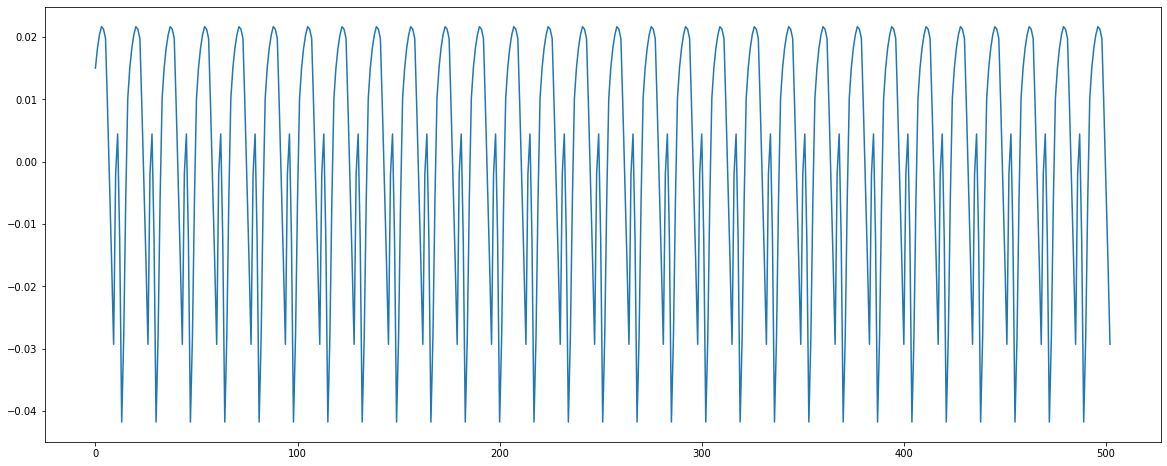

In [2]:
# try to predict trend: Extract trend
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(tsr[1][:], model='additive', period=17)
trend = result.seasonal.dropna()
trend.plot(figsize=(20,8))

In [3]:
#Check stationarity (p_value < 0.05)
from statsmodels.tsa.stattools import adfuller
adft = adfuller(trend,autolag='AIC')

#print them with info
print('Augmented Dickey-Fuller Test trends')

out = pd.Series(adft[0:4],index=['ADF test statistic','p-value','# lags used','# observations'])

for key,val in adft[4].items():
    out[f'critical value ({key})']=val
print(out)

Augmented Dickey-Fuller Test trends
ADF test statistic     -7.493703e+14
p-value                 0.000000e+00
# lags used             1.700000e+01
# observations          4.850000e+02
critical value (1%)    -3.443905e+00
critical value (5%)    -2.867518e+00
critical value (10%)   -2.569954e+00
dtype: float64


<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

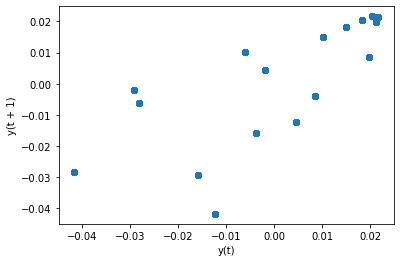

In [4]:
#Lags plot
from pandas.plotting import lag_plot

lag_plot(trend)  #check resid, seasonal

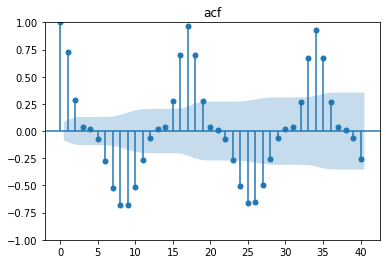

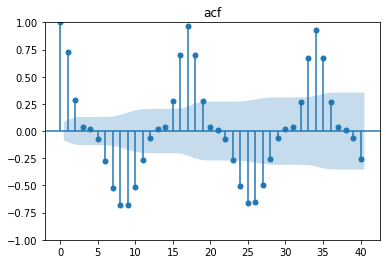

In [5]:
plot_acf(trend,title='acf',lags=40)

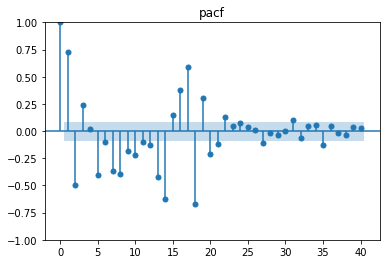

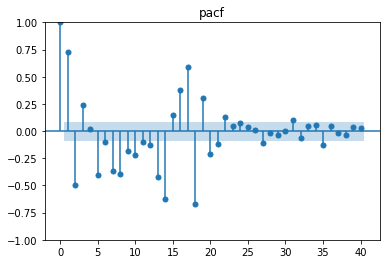

In [6]:
plot_pacf(trend,title='pacf',lags=40)

If the PACF displays a sharp cutoff while the ACF decays more slowly (i.e., has significant spikes at higher lags), we say that the stationarized series displays an "AR signature," meaning that the autocorrelation pattern can be explained more easily by adding AR terms than by adding MA terms.

In [7]:
auto_arima(trend)
# auto_arima(trend,seasonal=True,m=25)

ARIMA(order=(5, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [8]:
trend.describe()

count    503.000000
mean       0.000151
std        0.019304
min       -0.041764
25%       -0.012409
50%        0.004437
75%        0.018183
max        0.021652
Name: seasonal, dtype: float64

In [9]:
trend =tsr[1][:]

In [10]:
train = trend.iloc[:250]
test = trend.iloc[250:]

In [11]:
model = statsmodels.api.tsa.ARIMA(train, order=(5,0,1))
# model = statsmodels.api.tsa.SARIMAX(train,order=(3,0,0),seasonal_order=(0,0,0,25))

In [12]:
trends = model.fit()

In [13]:
trends.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      1   No. Observations:                  250
Model:                 ARIMA(5, 0, 1)   Log Likelihood                 425.191
Date:                Sun, 28 Jan 2024   AIC                           -834.381
Time:                        21:53:23   BIC                           -806.210
Sample:                             0   HQIC                          -823.043
                                - 250                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9451      1.533      1.269      0.204      -1.059       4.949
ar.L1          1.0862      0.123      8.804      0.000       0.844       1.328
ar.L2          0.5019      0.228      2.201      0.028       0.055       0.949
ar.L3         -0.5819      0.172     -3.379      0.001      -0.919      -0.244
ar.L4         -0.2372      0.121     -1.962      0.050      -0.474      -0.000
ar.L5          0.2260      0.057      3.939      0.000       0.114       0.338
ma.L1          0.8435      0.122      6.931      0.000       0.605       1.082
sigma2         0.0019   6.32e-05     29.880      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):             29390.07
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               0.22   Skew:                             4.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        55.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
start=len(train)
end=len(train)+len(test)-1
predictions = trends.predict(start=start, end=end, dynamic=False, typ='levels')

Passing <tt>dynamic=False</tt> means that forecasts at each point are generated using the full history up to that point (all lagged values).

Passing <tt>typ='levels'</tt> predicts the levels of the original endogenous variables. If we'd used the default <tt>typ='linear'</tt> we would have seen linear predictions in terms of the differenced endogenous variables.

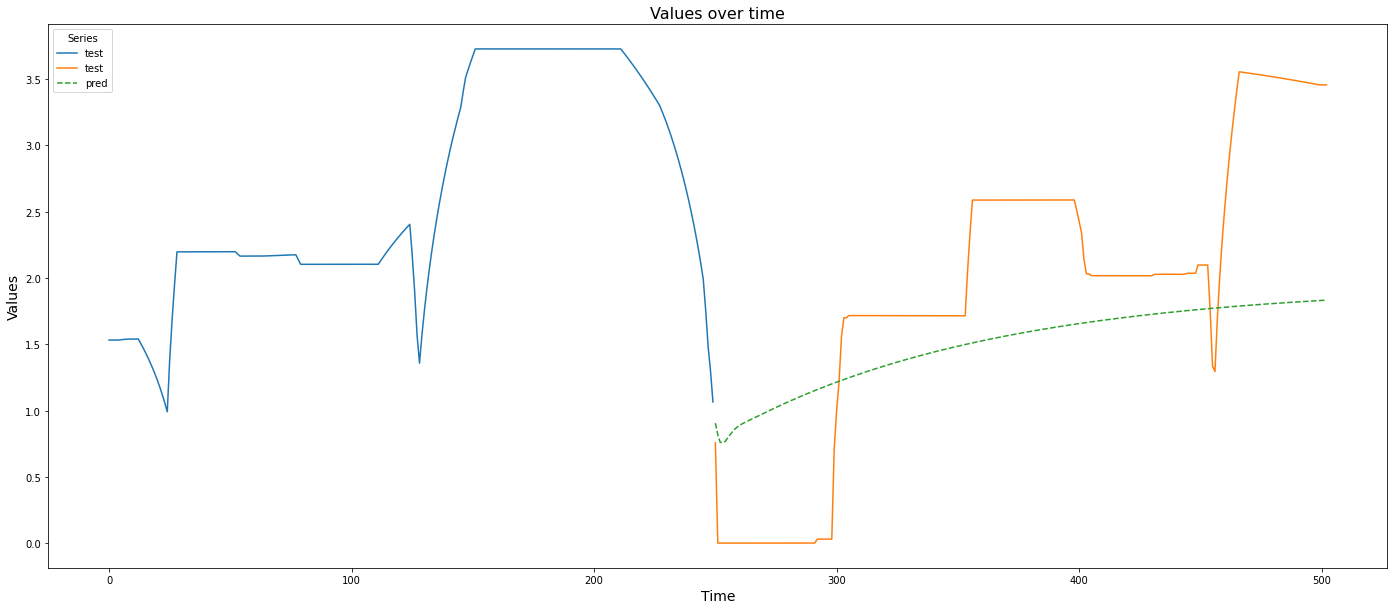

In [15]:
#define size
plt.figure(figsize=(24,10))
#add axes labels and a title
plt.ylabel('Values', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('Values over time', fontsize=16)
plt.plot(train,"-", label = 'test')
plt.plot(test,"-", label = 'test')
plt.plot(predictions,"--", label = 'pred')
#add legend
plt.legend(title='Series')

In [16]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test, predictions)
error

0.8817792212272256

In [17]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test, predictions)
error

0.939031001206683

In [18]:
trend.describe()

count    5.030000e+02
mean     2.260195e+00
std      1.039010e+00
min      4.440892e-16
25%      1.716426e+00
50%      2.167700e+00
75%      3.155995e+00
max      3.728593e+00
Name: 1, dtype: float64

In [19]:
model = statsmodels.api.tsa.ARIMA(trend,order=(5,0,1))
trends = model.fit()
fcast = trends.predict(len(trend),len(trend)+72,typ='levels')

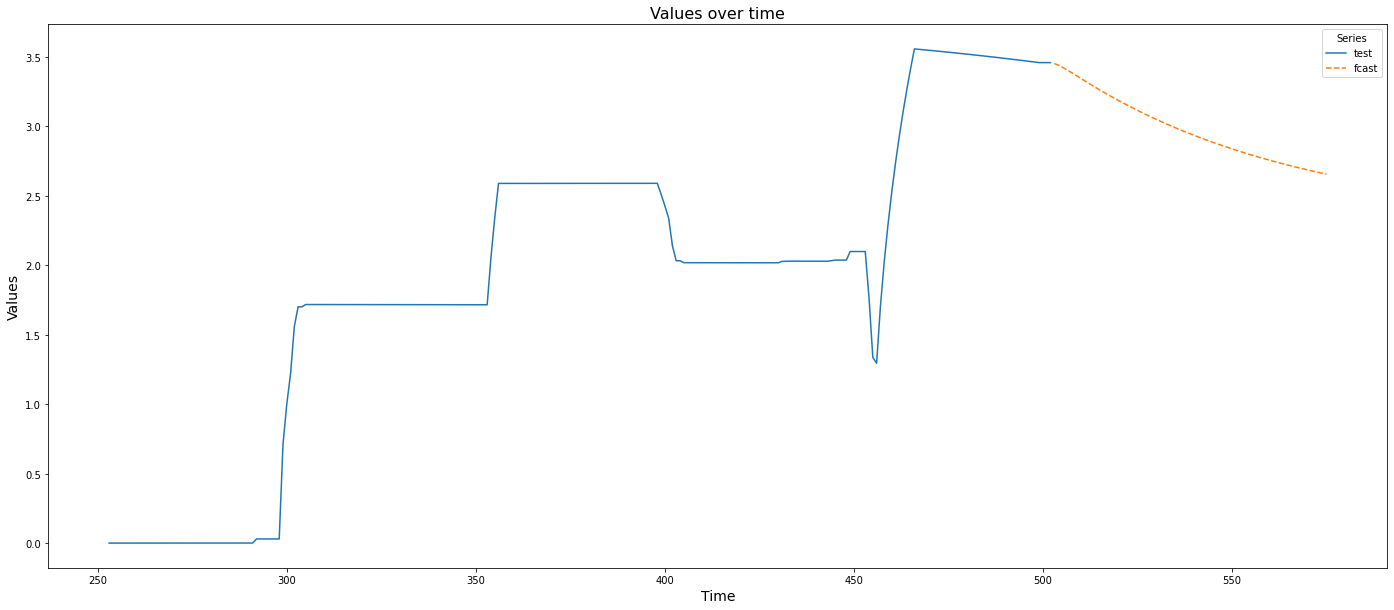

In [20]:
#define size
plt.figure(figsize=(24,10))
#add axes labels and a title
plt.ylabel('Values', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('Values over time', fontsize=16)
plt.plot(trend.iloc[-250:],"-", label = 'test')
plt.plot(fcast,"--", label = 'fcast')
#add legend
plt.legend(title='Series')

In [21]:
import pickle

# Save the model to a file
with open('std_Latency_model.pkl', 'wb') as file:
    pickle.dump(trends, file)